# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

# Machine Learning Model Design

In the previous video, you learnt to select the suitable machine learning model to predict the options strategy to deploy.
In this notebook, we will design the LSTM model with the input features and target variable created in the previous notebooks. 

The notebook is structured as follows:
1. [Import the Data](#read)
2. [Feature Encoding](#feature_encoding)
3. [Scale the Data](#scaling)
4. [Model Architecture](#model)
5. [Plot the Accuracy and Loss ](#plot)
6. [Accuracy Analysis of Model](#accuracy)


## Import Libraries

In [1]:
# Import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# To suppress the warnings
import warnings 
warnings.filterwarnings('ignore')


# Machine learning based libraries
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Dense, LSTM
from tensorflow.keras.optimizers import *
from keras import optimizers
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

# Set random seed
np.random.seed(11)

# For data visualisation
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('seaborn-v0_8-darkgrid')

2025-04-29 12:09:57.297115: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-29 12:10:08.195281: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-29 12:10:14.868995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-29 12:10:23.909188: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-29 12:10:26.198557: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-29 12:10:41.665518: I tensorflow/core/platform/cpu_feature_gu

<a id='read'></a>
## Import the Data

Import the file `underlying_data_model_mlo.csv` as `underlying_data` using the `read_csv` method of `pandas`. This file contains the underlying asset data, option chains data along with the target variable.

In [2]:
# Import the underlying data with option chain data and the target variable
underlying_data = pd.read_csv('../data_modules/underlying_data_model_mlo.csv')

Create the dataframe `model_data` with input features and the target variable.

In [3]:
# Create list 'model_columns' with input features, the target variable
model_columns = ['call_last',
                 'max_returns_strategy', 'dte', 'call_delta', 'call_gamma', 'call_vega',
                 'call_theta', 'call_rho', 'call_iv', 'put_delta', 'put_gamma',
                 'put_vega', 'put_theta', 'put_rho', 'put_iv', 'f_ret_1', 'f_ret_5',
                 'f_ret_10', 'f_ret_22', 'f_ret_44', 'f_ret_88', 'f_natr', 'f_rsi',
                 'f_norm_upper', 'f_norm_lower', 'f_norm_middle']

# Create the dataframe 'model_data' by selecting 'model_columns' from 'underlying_data'
model_data = underlying_data[model_columns]


Before we move forward, make sure the data types of the columns in the `model_data` are numerical.

In [4]:
model_data.dtypes

call_last               float64
max_returns_strategy     object
dte                     float64
call_delta              float64
call_gamma              float64
call_vega               float64
call_theta              float64
call_rho                float64
call_iv                  object
put_delta               float64
put_gamma               float64
put_vega                float64
put_theta               float64
put_rho                 float64
put_iv                   object
f_ret_1                 float64
f_ret_5                 float64
f_ret_10                float64
f_ret_22                float64
f_ret_44                float64
f_ret_88                float64
f_natr                  float64
f_rsi                   float64
f_norm_upper            float64
f_norm_lower            float64
f_norm_middle           float64
dtype: object

As you can see, the columns `max_returns_strategy`, `call_iv` and `put_iv` are not numerical. The column `max_returns_strategy` is the strategy label which will be converted into numerical datatype using one hot encoding. 

The columns `call_iv` and `put_iv` should be converted into numerical datatype.

In [5]:
# Convert the call_iv values into numeric dtype
model_data.call_iv = [x[1:] for x in model_data.call_iv]
model_data.call_iv = pd.to_numeric(model_data.call_iv)

# Convert the put_iv values into numeric dtype

model_data.put_iv = [x[1:] for x in model_data.put_iv]
model_data.put_iv = pd.to_numeric(model_data.put_iv)

model_data = model_data.dropna()

Create dependent variable(y) and independent variables(X) from `model_data`

In [6]:
# Store the data of input variables in X
X = model_data.drop(['max_returns_strategy'], axis=1)

# Store the target variable in y
y = model_data.max_returns_strategy.shift(-1).values
y

array(['strategy_3', 'strategy_1', 'strategy_1', ..., 'strategy_1',
       'strategy_1', None], dtype=object)

<a id='feature_encoding'></a>
## Feature Encoding
Machine learning models can only work with numerical values. For this reason, it is necessary to transform the categorical values of the relevant features into numerical ones. This process is called feature encoding.

The feature encoding can be done using `to_categorical` function of `keras utils` 

In [7]:
y_cat = to_categorical(pd.factorize(y)[0])
y_cat

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Create train, and test datasets with 80% and 20% data respectively

In [8]:
# Use test_size as 20%
test_size = int(0.2*(len(X)))

# Create train and test sets for dependent and independent variables
X_train = X[:-test_size]
X_test = X[-test_size:]
y_train = y[:-test_size]
y_test = y[-test_size:]

<a id='scaling'></a>
## Scale the Data

Scale the train and test data using the `StandardScaler()` method of `sklearn.preprocessing`

In [11]:
# Create the scaler object
scaler = StandardScaler()

# Scale the train data and store it in 'X_train_scaled'
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)

# Scale the test data and store it in 'X_test_scaled'
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

# Save the scaled independent variables in 'X_scaled'
X_scaled = pd.concat([X_train_scaled, X_test_scaled], axis=0)

Using timesteps of 20 days to create the input data

<i> <span style="color:#FFFFFF; background:#00C001"> The following cells will not run in the browser. Download this notebook and convert the cells to "Code" type to run. </i>

In [12]:
# Use 20 days as timesteps
timestep = 20

# Create X_list and y_list to save data of dependent and independent variables
X_list = []
y_list = []

# Create an array of scaled data at a length of timesteps
for i in range(timestep, len(X_scaled)):
    X_list.append(np.array(X_scaled[i-timestep:i]))
    y_list.append(y_cat[i])

# Create train and test sets for dependent and independent variables from X_list and y_list
X_train = np.array(X_list[:-test_size])
y_train = np.array(y_list[:-test_size])
X_test = np.array(X_list[-test_size:])
y_test = np.array(y_list[-test_size:])

In [13]:
# Distribution of classes in the training data
test_size = 484
round(100*underlying_data.max_returns_strategy[:-test_size].value_counts()/len(
    underlying_data[:-test_size]), 2)

max_returns_strategy
strategy_1     41.46
strategy_25    20.58
strategy_11     8.57
strategy_5      7.60
strategy_18     5.98
strategy_6      4.31
strategy_9      3.70
strategy_3      3.19
strategy_20     2.43
strategy_8      1.77
strategy_15     0.20
strategy_21     0.20
Name: count, dtype: float64

<a id='model'></a>
## Model Architecture

Create the LSTM model with the following architecture.
1. Create an input layer with 32 neurons and an input shape of X_train.shape[1], X_train.shape[2]
2. Add five hidden layers with 100 neurons each and the 'relu' activation function
3. Add the output layer with the number of strategies in the target variable and with the 'softmax' activation function
4. Add the 'adam' optimiser with the learning rate as 10^-4
5. Use the 'categorical_crossentropy' loss function
6. Use 'accuracy' as a metric of accuracy

In [14]:
# Set random seed to get reproducible results
tf.random.set_seed(3)
# Set neurons as 100
neurons = 100
# Define the 'relu' activation function
act = 'relu'
# use 0.2 as dropout_ratio
dropout_ratio = 0.2
# Define sequential model
model = Sequential()
# Add the input layer - set return_sequences=False to only keep last output
model.add(LSTM(32, input_shape=(
    X_train.shape[1], X_train.shape[2]), return_sequences=False))
# Add 5 hidden layers
model.add(Dense(neurons, activation=act))
model.add(Dropout(dropout_ratio))
model.add(Dense(neurons, activation=act))
model.add(Dropout(dropout_ratio))
model.add(Dense(neurons, activation=act))
model.add(Dropout(dropout_ratio))
model.add(Dense(neurons, activation=act))
model.add(Dropout(dropout_ratio))
model.add(Dense(neurons, activation=act))
model.add(Dropout(dropout_ratio))
# Add the output layer
model.add(Dense(len(model_data.max_returns_strategy.unique()), activation='softmax'))
# Define the adam optimiser with the learning rate of 10^-4
optimiser_def = Adam(learning_rate=1e-4)
# Compile the model with loss function, optimiser and metrics
model.compile(loss='categorical_crossentropy',
              optimizer=optimiser_def, metrics=['accuracy'])
# Print the model
model.summary()
# Fit the model on train data with 100 epochs, 32 batch size and validation split of 0.2
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                    validation_split=0.2)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         7,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │         3,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │         1,212 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,336 (204.44 KB)

 Trainable params: 52,336 (204.44 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.2841 - loss: 2.4374 - val_accuracy: 0.4453 - val_loss: 2.3512
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.3952 - loss: 2.3036 - val_accuracy: 0.4453 - val_loss: 2.0746
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3966 - loss: 2.0203 - val_accuracy: 0.4453 - val_loss: 1.8602
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3997 - loss: 1.9354 - val_accuracy: 0.4453 - val_loss: 1.8431
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3962 - loss: 1.9127 - val_accuracy: 0.4453 - val_loss: 1.8337
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3993 - loss: 1.8744 - val_accuracy: 0.4453 - val_loss: 1.8228
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4012 - loss: 1.8586 - val_accuracy: 0.4453 - val_loss: 1.8138
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4010 - loss: 1.8464 - val_accuracy: 0

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5212 - loss: 1.5804 - val_accuracy: 0.4974 - val_loss: 1.7133
Epoch 52/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5157 - loss: 1.5776 - val_accuracy: 0.4974 - val_loss: 1.7225
Epoch 53/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5207 - loss: 1.5669 - val_accuracy: 0.4974 - val_loss: 1.7120
Epoch 54/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5256 - loss: 1.5610 - val_accuracy: 0.4974 - val_loss: 1.7183
Epoch 55/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5185 - loss: 1.5591 - val_accuracy: 0.4948 - val_loss: 1.7184
Epoch 56/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5184 - loss: 1.5401 - val_accuracy: 0.4974 - val_loss: 1.7191
Epoch 57/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5241 - loss: 1.5683 - val_accuracy: 0.5026 - val_loss: 1.7176
Epoch 58/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5343 - loss: 1.5301 - val_accuracy: 0.5052 

<a id='plot'></a>
## Plot the Accuracy and Loss 

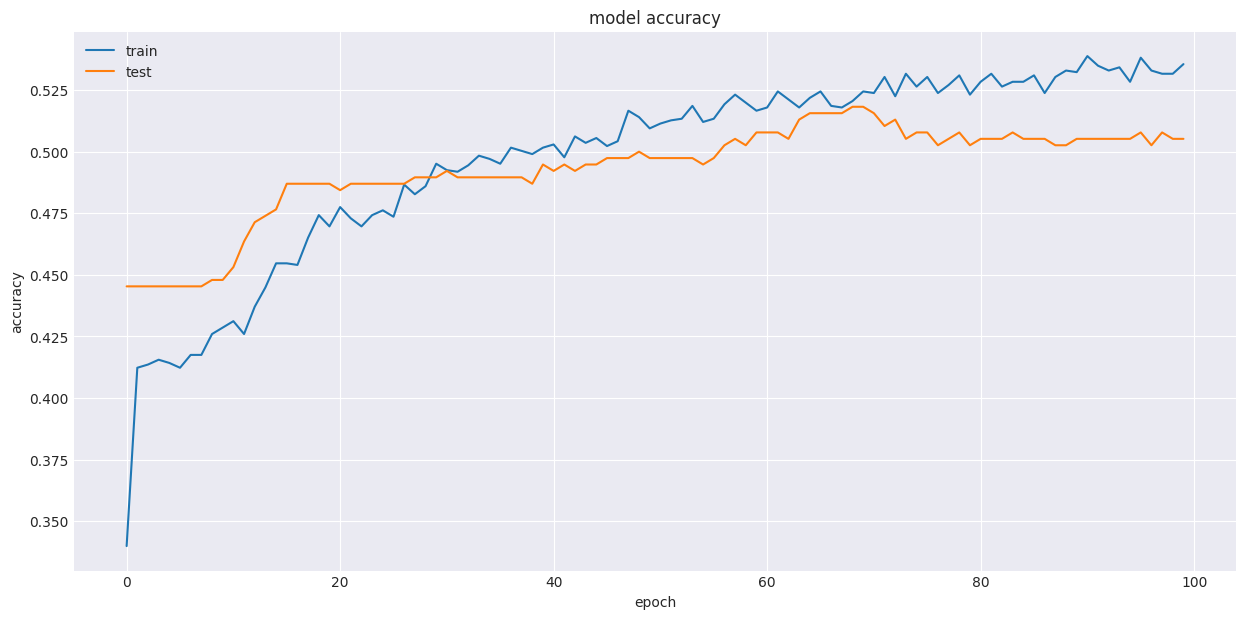

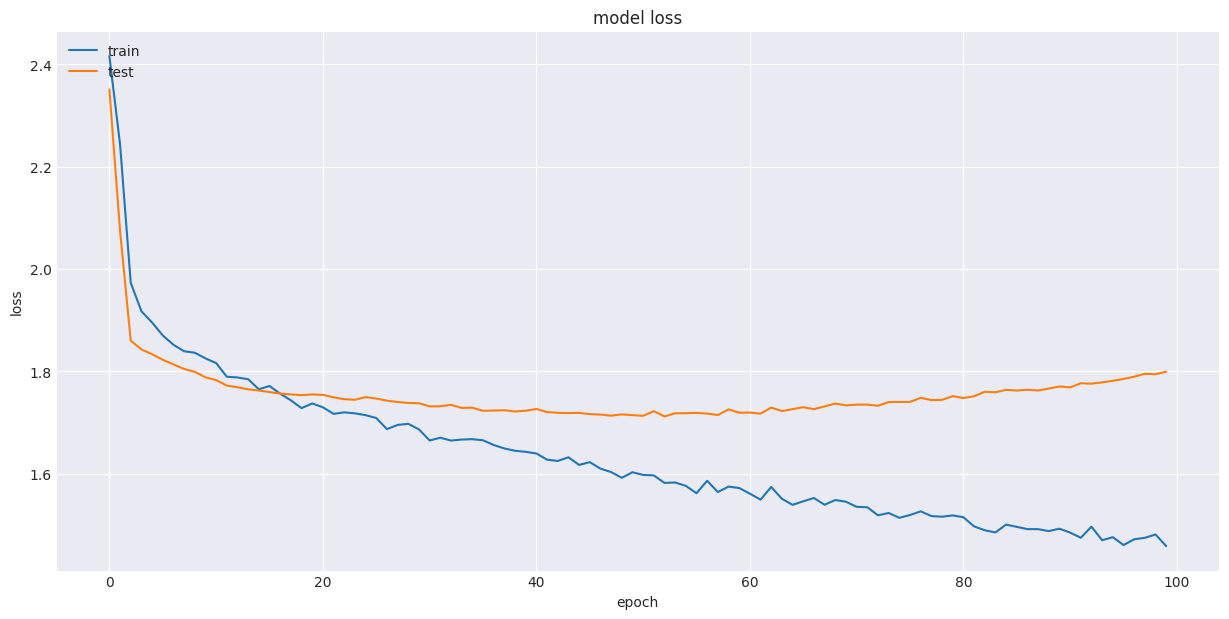

In [15]:
# Set the figure size
figure(figsize=(15, 7))

# Plot training accuracy
plt.plot(history.history['accuracy'])

# Plot validation accuracy
plt.plot(history.history['val_accuracy'])

# Define plot title
plt.title('model accuracy')

# Define x and y  labels
plt.ylabel('accuracy')
plt.xlabel('epoch')

# Add legend
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Set the figure size
figure(figsize=(15, 7))

# Plot training loss
plt.plot(history.history['loss'])

# Plot validation loss
plt.plot(history.history['val_loss'])

# Define plot title
plt.title('model loss')

# Define x and y  labels
plt.ylabel('loss')
plt.xlabel('epoch')

# Add legend
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The accuracy and loss worsened for train dataset as the epochs increased. This is because of the class imbalance in the test dataset. This can be imporved and by changing the test dataset and also perfoming hyperparameter turning of the ML model.
<a id='accuracy'></a>
## Accuracy Analysis of Model

Predict the target variables of the test dataset. Reverse one-hot encode the predicted labels and test labels to perform accuracy analysis

In [ ]:
# Predict the target variable of the test dataset
pred = model.predict(X_test)

# Since we modified the model to use return_sequences=False,
# the prediction output is now 2D (batch_size, num_classes) instead of 3D

# Print shapes to understand the data structure
print(f"Prediction shape: {pred.shape}")
print(f"y_test shape: {y_test.shape}")

# Convert predictions to class labels
pred_labels = [model_data.max_returns_strategy.unique()[np.argmax(p)] for p in pred]

# Convert one-hot encoded test labels to class labels
test_labels = [model_data.max_returns_strategy.unique()[np.argmax(y)] for y in y_test]

# Print classification report
print(classification_report(test_labels, pred_labels))

# If you want to see the confusion matrix as well:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create and plot confusion matrix
cm = confusion_matrix(test_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model_data.max_returns_strategy.unique(),
            yticklabels=model_data.max_returns_strategy.unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Prediction shape: (484, 12)
y_test shape: (484, 12)
              precision    recall  f1-score   support

  strategy_1       0.00      0.00      0.00         4
 strategy_11       0.00      0.00      0.00        44
 strategy_15       0.00      0.00      0.00         1
 strategy_18       0.00      0.00      0.00        21
 strategy_20       0.46      0.43      0.44        87
 strategy_21       0.00      0.00      0.00         3
 strategy_25       0.07      0.12      0.09        34
  strategy_3       0.44      0.80      0.57       192
  strategy_5       0.00      0.00      0.00        33
  strategy_6       0.00      0.00      0.00        23
  strategy_8       0.00      0.00      0.00        16
  strategy_9       0.00      0.00      0.00        26

    accuracy                           0.40       484
   macro avg       0.08      0.11      0.09       484
weighted avg       0.26      0.40      0.31       484



## Conclusion

The model predicted 6 strategies out of 10 labels. Let's backtest this model by taking positions as per predicted labels in the following notebook.